In [78]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['recognizing-faces-in-the-wild', 'imagenet-models']


In [79]:
# Random
import random
from tqdm import tqdm_notebook
# Library for reading images 
from PIL import Image
# Plotting library
from matplotlib import pyplot as plt

In [80]:
# TRAIN DATA and manipulations:
###############################

train_df= pd.read_csv("../input/recognizing-faces-in-the-wild/train_relationships.csv")
train_df.shape

(3598, 2)

In [81]:
train_df.tail()

,p1,p2
3593,F1000/MID5,F1000/MID8
3594,F1000/MID5,F1000/MID9
3595,F1000/MID6,F1000/MID9
3596,F1000/MID7,F1000/MID8
3597,F1000/MID7,F1000/MID9


In [82]:
families_number = sorted(os.listdir("../input/recognizing-faces-in-the-wild/train/"))
print("There are {} families in the train set". format(len(families_number)))
print(families_number[:10])
members = {i:sorted(os.listdir(("../input/recognizing-faces-in-the-wild/train/")+i)) for i in families_number}
#print(members)

There are 470 families in the train set
['F0002', 'F0005', 'F0009', 'F0010', 'F0016', 'F0017', 'F0020', 'F0022', 'F0023', 'F0024']


In [83]:
#train_im = "../input/recognizing-faces-in-the-wild/train"
#train_images = os.listdir(train_im)
#print(train_images[:10])

In [84]:
# TEST DATA and manipulations:
###############################
test_path= "../input/recognizing-faces-in-the-wild/test"
test_images_name = os.listdir(test_path)
print("Number of images in test set:", len(test_images_name))

Number of images in test set: 6282


In [85]:
def load_img(PATH): 
    return np.array(Image.open(PATH))

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [86]:
# To convert images into a matrix
test_images=np.array([load_img(os.path.join(test_path,image)) for image in test_images_name])

In [87]:
print(test_images.shape)

(6282, 224, 224, 3)


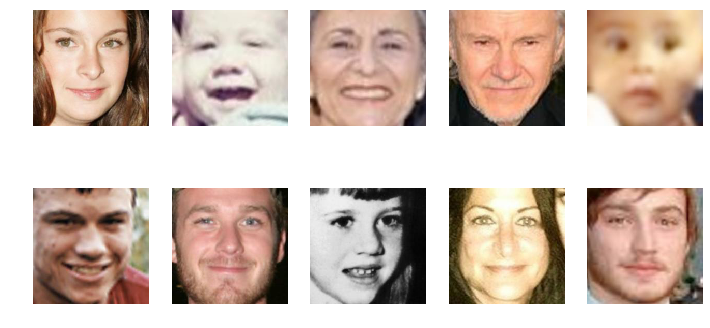

In [88]:
plots(test_images[:10], rows =2)

In [89]:
# LOAD MODEL FROM KERAS
########################

from keras.applications.densenet import DenseNet121 #Load trained Densenet121

def CNNdensenet (weights=None):
    model = DenseNet121(include_top=True, weights=None, input_tensor=None, input_shape=None, pooling=None, classes=1000)
    return model

In [90]:
#path_weights = "../input/imagenet_models/densenet121_weights_tf.h5" #load trained weights
path_weights = "../input/imagenet_models/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5" #load trained weights

CNN= CNNdensenet(weights=path_weights)
CNN.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 230, 230, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [91]:
# To check results with the train set:

im = Image.open('../input/recognizing-faces-in-the-wild/train/F1000/MID4/P10582_face1.jpg')
im = np.array(im).astype(np.float32)
im2 = Image.open('../input/recognizing-faces-in-the-wild/train/F1000/MID4/P10582_face1.jpg')
im2 = np.array(im2).astype(np.float32)

im = np.expand_dims(im, axis=0)

im2 = np.expand_dims(im2, axis=0)
np.concatenate([im,im2]).shape

(2, 224, 224, 3)

In [92]:
out = CNN.predict(np.concatenate([im,im2]))

print("Out dimension, one probe with 2 elements of train set:", out.shape)
def distance(x, y):
    return np.linalg.norm(x - y)
train_check= print("distance between 2 images of training set:", distance(out[0], out[1]))

Out dimension, one probe with 2 elements of train set: (2, 1000)
distance between 2 images of training set: 0.0


In [93]:
# Read test set, CAREFUL¡¡¡¡¡¡ with the time and To calculate embedings of TEST set:

test_images = os.listdir(test_path)
test = np.array([load_img(os.path.join(test_path, i)) for i in test_images])
test_emb = CNN.predict(test)
print(test.shape, test_emb.shape) # TEst_emp esta normalizado

(6282, 224, 224, 3) (6282, 1000)


In [94]:
# To assign index to each image:
image_index = {imagen_numero:idx for idx, imagen_numero in enumerate(test_images)}

In [95]:
submission = pd.read_csv('../input/recognizing-faces-in-the-wild/sample_submission.csv')

splitting = [i.split('-') for i in submission.img_pair]  #por "-" , se divide un campo en dos
print("number of pairs for testing:", len(splitting))

distances  = []
for i in splitting:
    a=i[0]
    b=i[1]
    dist= distance(test_emb[image_index[a]], test_emb[image_index[b]])
    distances.append(dist)

distances = np.array(distances)/np.max(distances)
probability = 1- ((distances/np.max(distances)))# (0.2 is a security coeffcient)
print("distances:", distances)
print("Max distance:", np.max(distances))
print("Min distance:", np.min(distances))
print("Sum distances:", distances.sum()) 
print("Probabilities:", probability)
print("Max probability:", np.max(probability))


submission.head()

number of pairs for testing: 5310
distances: [0.5943371  0.17600521 0.08491609 ... 0.121727   0.14766796 0.38392317]
Max distance: 1.0
Min distance: 0.007092792
Sum distances: 1466.9926
Probabilities: [0.4056629  0.82399476 0.9150839  ... 0.878273   0.85233206 0.6160768 ]
Max probability: 0.9929072


,img_pair,is_related
0,face05508.jpg-face01210.jpg,0
1,face05750.jpg-face00898.jpg,0
2,face05820.jpg-face03938.jpg,0
3,face02104.jpg-face01172.jpg,0
4,face02428.jpg-face05611.jpg,0


In [96]:
submission.is_related = probability
submission.to_csv('submission_SMILE3.csv', index=False)
submission.head()

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0.405663
1,face05750.jpg-face00898.jpg,0.823995
2,face05820.jpg-face03938.jpg,0.915084
3,face02104.jpg-face01172.jpg,0.898379
4,face02428.jpg-face05611.jpg,0.888090


In [97]:
print(os.listdir("../working"))

['submission_SMILE1.csv', '__notebook_source__.ipynb', '.ipynb_checkpoints', 'submission_SMILE2.csv', 'submission_SMILE3.csv']
